In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Replace NAN values with the column's mean value

In [4]:
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)

df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [5]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that while fare has a mean of 32.2, it has some particularily large values. To avoid these values from dominating during matrix multiplication, we can take the logarithm of all fares. This makes the distribution more even.

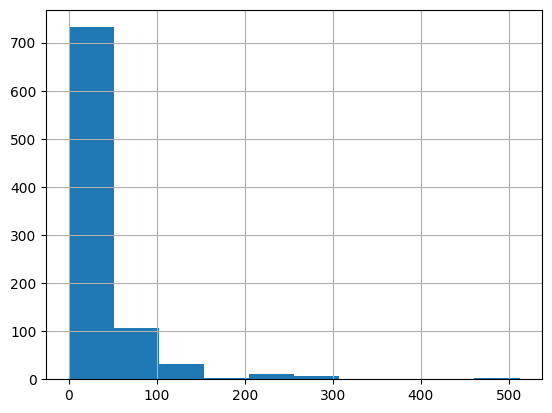

In [6]:
df['Fare'].hist();

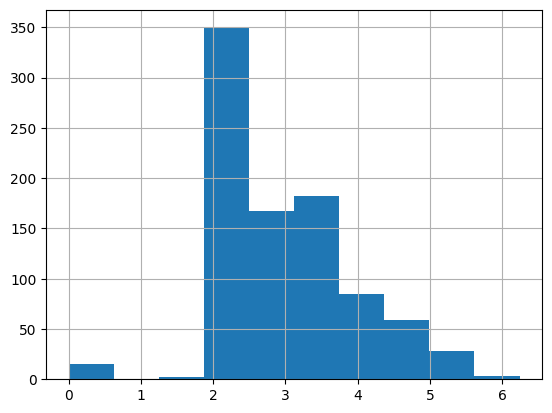

In [7]:
df['LogFare'] = np.log(df['Fare']+1)
df['LogFare'].hist();

In [8]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [9]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


In [10]:
from torch import tensor

t_dep = tensor(df.Survived)

In [11]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

df[indep_cols] = df[indep_cols].astype({col: 'int' for col in df[indep_cols].select_dtypes('bool').columns})

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

Create coefficients for every column in t_indep

In [12]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

Convert all data into integer between 0 and 1 by divided by the column's maximum

In [13]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

Find predictions & calculate loss.

In [14]:
coeffs.requires_grad_()

def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

loss = calc_loss(coeffs, t_indep, t_dep)
print(loss)

tensor(0.5112, grad_fn=<MeanBackward0>)


Now, let's perform gradient descent to improve the linear model.

In [15]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5092)


Time to train the model; first, we must split the data into respective training and validation sets

In [16]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

First, create update_coeffs, one_epoch and init_coeffs function

In [17]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [18]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [19]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

Now we can assemble a function that trains the linear model.

In [20]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

Train model. I found lr=0.34 returns the best accuracy for this linear model.

In [21]:
coeffs = train_model(18, lr=105)
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

0.510; 0.327; 0.301; 0.211; 0.202; 0.198; 0.197; 0.197; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 

{'Age': tensor(-1.6269),
 'SibSp': tensor(-0.8522),
 'Parch': tensor(-0.1810),
 'LogFare': tensor(0.2116),
 'Sex_male': tensor(-10.7813),
 'Sex_female': tensor(8.3944),
 'Pclass_1': tensor(3.8435),
 'Pclass_2': tensor(1.6611),
 'Pclass_3': tensor(-6.2325),
 'Embarked_C': tensor(1.1977),
 'Embarked_Q': tensor(1.6803),
 'Embarked_S': tensor(-4.5533)}

Calculate absolute error (the loss function)

In [22]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.8258)

I noticed that when testing for learning ranges (iterating 1-100) with a sigmoid function, the loss remains the same throughout.  

In [23]:
err = []
for i in range(200):
    err.append(acc(train_model(18, lr=i)))

err

0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.510; 0.489; 0.468; 0.449; 0.431; 0.416; 0.402; 0.391; 0.381; 0.372; 0.365; 0.358; 0.352; 0.346; 0.341; 0.336; 0.331; 0.327; 0.510; 0.468; 0.430; 0.401; 0.379; 0.363; 0.350; 0.340; 0.330; 0.322; 0.315; 0.308; 0.302; 0.296; 0.291; 0.286; 0.282; 0.278; 0.510; 0.448; 0.399; 0.369; 0.349; 0.334; 0.321; 0.310; 0.301; 0.293; 0.285; 0.279; 0.274; 0.269; 0.265; 0.261; 0.258; 0.255; 0.510; 0.429; 0.376; 0.348; 0.329; 0.313; 0.300; 0.289; 0.281; 0.273; 0.267; 0.262; 0.258; 0.254; 0.251; 0.248; 0.246; 0.244; 0.510; 0.412; 0.359; 0.332; 0.313; 0.297; 0.284; 0.274; 0.267; 0.260; 0.255; 0.251; 0.248; 0.245; 0.242; 0.240; 0.238; 0.237; 0.510; 0.396; 0.345; 0.319; 0.299; 0.284; 0.272; 0.263; 0.257; 0.252; 0.248; 0.244; 0.241; 0.239; 0.237; 0.235; 0.233; 0.232; 0.510; 0.382; 0.335; 0.308; 0.288; 0.273; 0.263; 0.255; 0.250; 0.245; 0.242; 0.239; 0.237; 0.234; 0.233; 0.231; 0.230;

[tensor(0.3315),
 tensor(0.7921),
 tensor(0.8258),
 tensor(0.7978),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7921),
 tensor(0.7978),
 tensor(0.8034),
 tensor(0.8202),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8315),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258),
 tensor(0.8258

Now submit:

In [24]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_df[indep_cols] = tst_df[indep_cols].astype({col: 'int' for col in tst_df[indep_cols].select_dtypes('bool').columns})
tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)